<a href="https://colab.research.google.com/github/YChen1212/Food-Delivery-EDA-Analysis/blob/main/Food_Dlivery_Profits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **外送平台獲益分析**



一、 **資料載入及瀏覽**

二、 **資料預先處理 & 清洗**

三、 **EDA : 辨別流失因素**

四、 **模型建立**

五、 **結論分析**



---


一、 資料載入及瀏覽

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from google.colab import drive

1.1讀取google drive檔案，並初步了解資料結構及各欄位之資料型態

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/python練習/food_orders.csv')
df.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,NaN,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


1.2檢視各欄位之空值數量

In [ ]:
df.isna().sum()

,0
Order ID,0
Customer ID,0
Restaurant ID,0
Order Date and Time,0
Delivery Date and Time,0
Order Value,0
Delivery Fee,0
Payment Method,0
Discounts and Offers,185
Commission Fee,0


1.3檢視各欄位之資料型態

In [ ]:
df.info()
# 有185個訂單沒有折扣

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    815 non-null    object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


1.4檢視數值型欄位的統計摘要

In [ ]:
df.describe()

,Order ID,Order Value,Delivery Fee,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,1053.969000,28.620000,126.99000,29.832000,28.300000
std,288.819436,530.975339,16.958278,43.06405,11.627165,49.614228
min,1.000000,104.000000,0.000000,50.00000,10.000000,0.000000
25%,250.750000,597.750000,20.000000,90.00000,20.000000,0.000000
50%,500.500000,1038.500000,30.000000,127.00000,30.000000,0.000000
75%,750.250000,1494.000000,40.000000,164.00000,40.000000,50.000000
max,1000.000000,1995.000000,50.000000,200.00000,50.000000,150.000000


---


二、 資料預先處理 & 清洗

2.1針對日期/時間欄位做預先處理

In [ ]:
df['Order Date and Time']  = pd.to_datetime(df['Order Date and Time'])
df['Delivery Date and Time']= pd.to_datetime(df['Delivery Date and Time'])
# 原始Order/Delivery Date and Time是object type，轉換為日期時間型態
df['Order Hour'] = df['Order Date and Time'].dt.hour
df['Delivery Hour']= df['Delivery Date and Time'].dt.hour
# 後續用以分析各時段的獲益
df['Delivery Duration'] = (df['Delivery Date and Time']-df['Order Date and Time']).dt.total_seconds()/60
# 後續用以分析送餐時間與獲益/退款是否有相關

In [ ]:
df['Weekday'] = df['Delivery Date and Time'].dt.strftime('%A')
# 後續用以分析週一~週日的獲益

2.2針對Discount相關欄位做預先處理

In [ ]:
# 因原始折扣欄位混亂，故自定清理函數
def discount_value(dis_val):
  if isinstance(dis_val, str) and '%' in dis_val:
    val_1=dis_val.split('%')[0]
    val_2 = (val_1.strip())
    val_3 = int(val_2)/100
    return val_3
  elif isinstance(dis_val, str) and 'off' in dis_val:
    val_1 = dis_val.split(' ')[0]
    val_2 = val_1.strip()
    return int(val_2)
  elif isinstance(dis_val, str) and 'None' in dis_val:
    return 0
  return 0

In [ ]:
def discount_type(dis_val):
  if isinstance(dis_val, str) and 'New' in dis_val:
    return 'New User'
  elif isinstance(dis_val, str) and 'App' in dis_val:
    return 'App'
  elif isinstance(dis_val, str) and 'Promo' in dis_val:
    return 'Promotion'
  else:
    return 'No Discount'

In [ ]:
# 新建折扣金額/百分比欄位，以便後續計算實際之折扣金額
df['Discount Value'] = df['Discounts and Offers'].apply(discount_value)

In [ ]:
# 新建折扣類型欄位
df['Discount Type'] = df['Discounts and Offers'].apply(discount_type)

In [ ]:
# 新建折扣金額欄位
df['Discount Amount'] = np.where((0<df['Discount Value']) & (df['Discount Value']<1), df['Order Value']*df['Discount Value'], df['Discount Value'])

2.3新增Profit欄位

In [ ]:
df['Profit'] = df['Order Value']- df['Delivery Fee']- df['Discount Amount']- df['Commission Fee']- df['Payment Processing Fee']- df['Refunds/Chargebacks']

2.4定義餐點時間

In [ ]:
def mealtime(hr):
  if hr >= 4 and hr <= 10:
    return 'Breakfast\n5:00~10:00'
  elif hr >10 and hr <= 14:
    return 'Lunch\n10:00~14:00'
  elif hr>14 and hr <= 17:
    return 'Afternoon Tea\n14:00~17:00'
  elif hr > 17 and hr <=22:
    return 'Dinner\n17:00~22:00'
  else:
    return 'Late Night Snack\n22:00~5:00'

In [ ]:
df['Meal Time'] = df['Order Hour'].apply(mealtime)
df['Meal Time']

,Meal Time
0,Late Night Snack\n22:00~5:00
1,Dinner\n17:00~22:00
2,Breakfast\n5:00~10:00
3,Dinner\n17:00~22:00
4,Late Night Snack\n22:00~5:00
...,...
995,Breakfast\n5:00~10:00
996,Breakfast\n5:00~10:00
997,Breakfast\n5:00~10:00
998,Dinner\n17:00~22:00




---


三、 EDA

3.1繪製Discount Type圓餅圖

Discount Type
No Discount    418
Promotion      201
New User       198
App            183
Name: count, dtype: int64


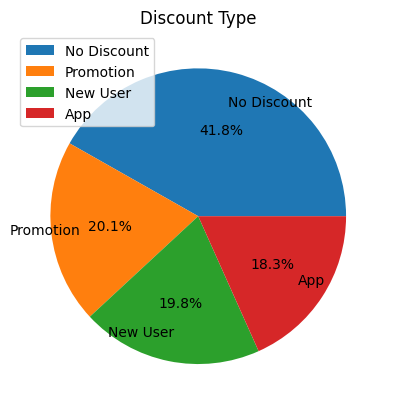

In [ ]:
count_discount_type = df['Discount Type'].value_counts()
print(count_discount_type)
plt.pie(count_discount_type, labels=count_discount_type.index, labeldistance=0.8, autopct='%1.1f%%')
plt.title('Discount Type')
plt.legend()
plt.show()

圖形分析：
* 無折扣的訂單數量最多，其餘有折扣的項目，其數量無顯著差異

3.2繪製各外送時長頻率直條圖

/tmp/ipython-input-18-629483855.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


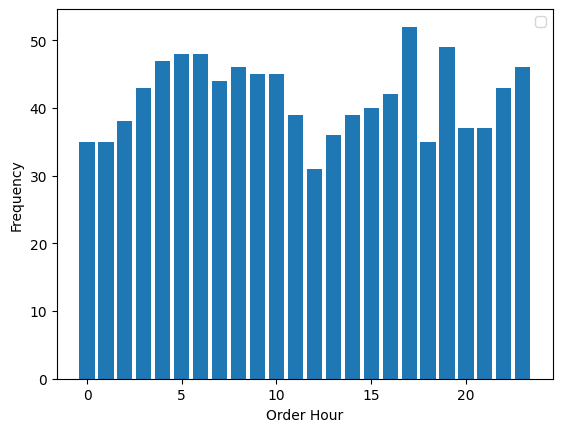

In [ ]:
count_deliveryhour = df['Order Hour'].value_counts().sort_index()
plt.bar(count_deliveryhour.index, count_deliveryhour.values)
plt.xlabel('Order Hour')
plt.ylabel('Frequency')
plt.legend()
plt.show()

/tmp/ipython-input-19-4004590691.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


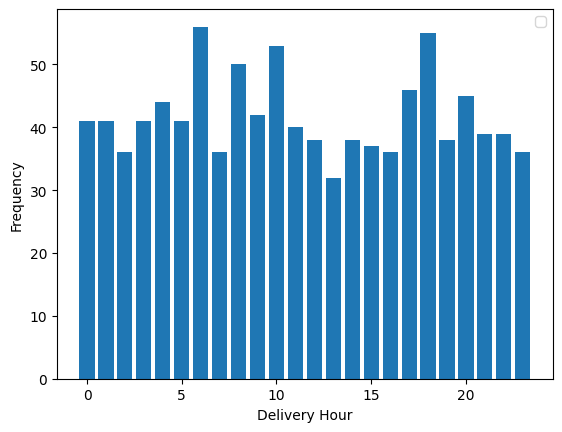

In [ ]:
count_deliveryhour = df['Delivery Hour'].value_counts().sort_index()
plt.bar(count_deliveryhour.index, count_deliveryhour.values)
plt.xlabel('Delivery Hour')
plt.ylabel('Frequency')
plt.legend()
plt.show()

圖形分析：

* 於外送時段6:00,8:00,10:00,18:00送達的訂單數量>=50次，若有較多外送員可能可提高配送速度和顧客滿意度。
* 於點餐時段12:00的訂單最少，若想增加該時段的訂單數量，可以推出限時優惠或促銷活動，以刺激需求。

3.3繪製類別型欄位&非連續型數值欄位與Profit關係之長條圖

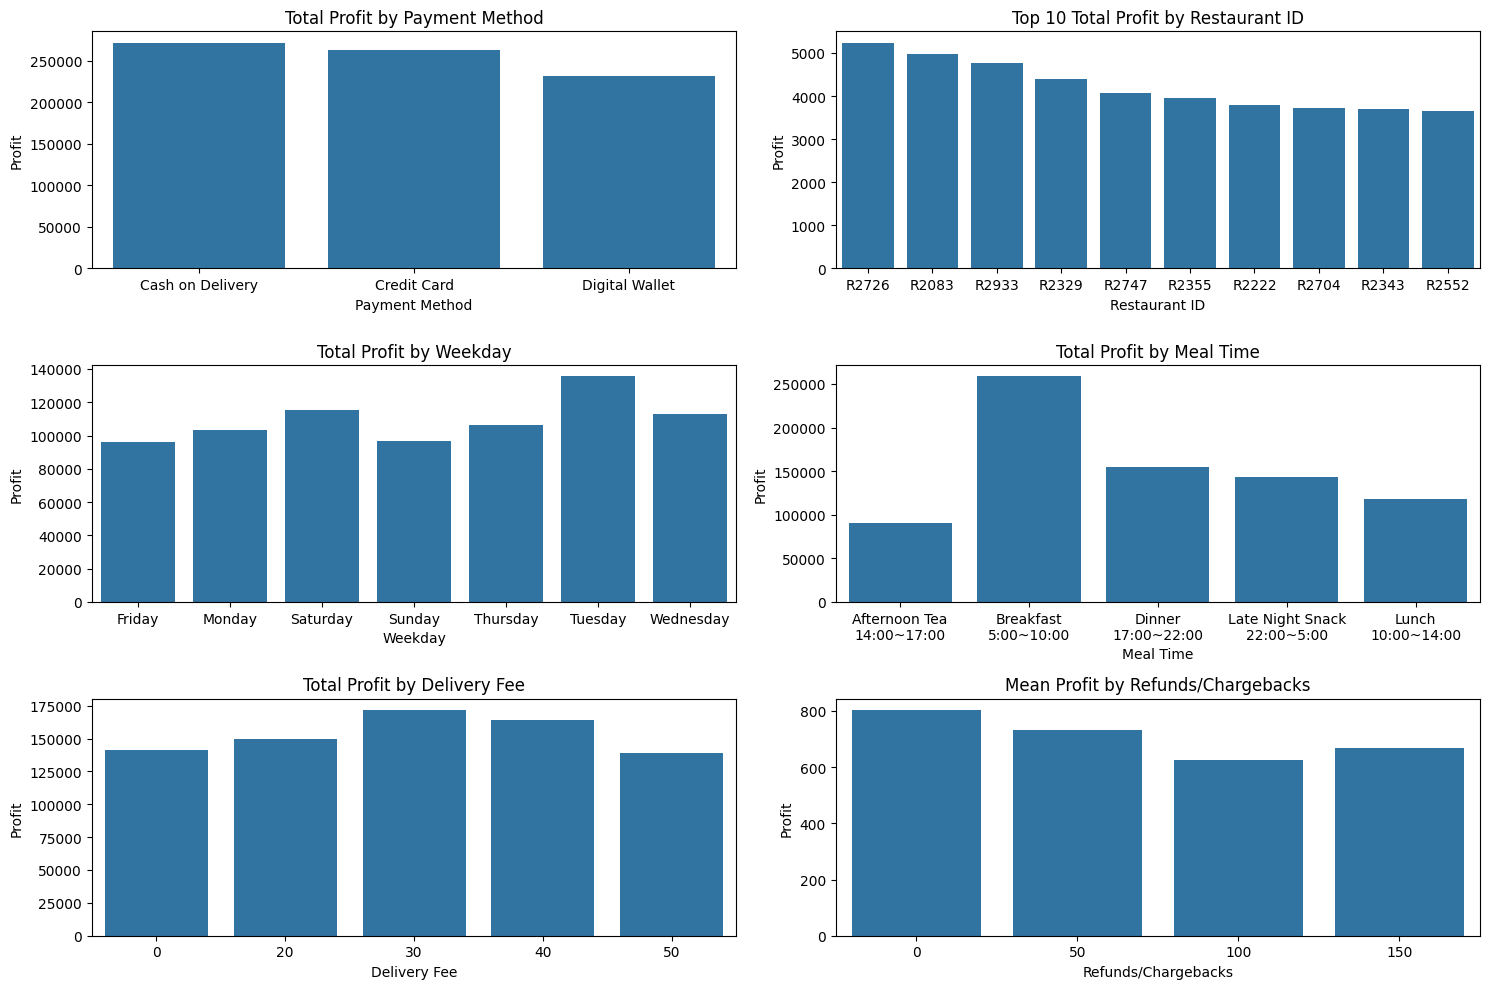

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15,10))

profit_paymethod = df[['Payment Method', 'Profit']].groupby('Payment Method').sum().reset_index()
sns.barplot(data=profit_paymethod, x='Payment Method', y='Profit', ax=axes[0][0])
axes[0][0].set_title('Total Profit by Payment Method')

profit_restaurant_top10 = df[['Restaurant ID', 'Profit']].groupby('Restaurant ID').sum().sort_values(by='Profit', ascending=False).head(10).reset_index()
sns.barplot(data=profit_restaurant_top10, x ='Restaurant ID', y='Profit', ax=axes[0][1])
axes[0][1].set_title('Top 10 Total Profit by Restaurant ID')

profit_weekday = df[['Weekday', 'Profit']].groupby('Weekday').sum().reset_index()
sns.barplot(data=profit_weekday, x='Weekday', y='Profit', ax=axes[1][0])
axes[1][0].set_title('Total Profit by Weekday')

profit_mealtime = df[['Meal Time', 'Profit']].groupby('Meal Time').sum().reset_index()
sns.barplot(data=profit_mealtime, x='Meal Time', y='Profit', ax=axes[1][1])
axes[1][1].set_title('Total Profit by Meal Time')

profit_deliveryfee = df[['Delivery Fee', 'Profit']].groupby('Delivery Fee').sum().reset_index()
sns.barplot(data=profit_deliveryfee, x='Delivery Fee', y='Profit', ax=axes[2][0])
axes[2][0].set_title('Total Profit by Delivery Fee')

profit_refund = df[['Refunds/Chargebacks', 'Profit']].groupby('Refunds/Chargebacks').mean().reset_index()
sns.barplot(data=profit_refund, x='Refunds/Chargebacks', y='Profit', ax=axes[2][1])
axes[2][1].set_title('Mean Profit by Refunds/Chargebacks')


plt.tight_layout()
plt.show()

圖形分析：

* 支付方式以電子錢包較少，若要增加電子錢包的使用率，可在使用者使用初期提供補貼或折扣。
* 可了解獲益前10名餐廳，其餐廳性質、熱門餐點項目，日後可增加與類似性質餐廳的合作機會。
* 通常會是週末或是週五晚上獲利較多，然而以圖表來看，週二獲益最多，故可深入研究星期二高獲益原因，例如了解星期二的訂單來源（哪間餐廳、是否為企業客戶/個人用戶）、訂單類型（早餐/午餐/晚餐）、訂單價值等等，再複製星期二的成功模式。
* 早餐時段獲益最多，需再進一步了解原因為何，可能係早餐時段的平台競爭者較少或是平台競爭者在早餐服務上的表現較弱等等，應繼續鞏固早餐市場，例如招募更多早餐合作夥伴、推出早餐套餐優惠或早鳥優惠。
* 外送費用以$30的總獲利最高，原因可能係該運費金額既可以被顧客接受，且其訂單的金額亦高。免運及$50的總獲利相較較少，可能原因為，免運需由外送平台自行吸收運送成本，導致獲益下降，應僅作為短期刺激訂單數量之策略，而$50可能係外送費用較高，導致訂單數量下降，應僅針對少數遠距離或特殊訂單而訂定。

* 退款/退單為$0平均獲益最高，因沒有額外損失，故避免退款是提升獲益直接的方式。$50獲益次之，然而再來係$150，退款金額為$150的平均獲利較$100高，可能係因$150退款之訂單數量較少，導致極端值對獲利之影響大。應針對退款金額為$100及$150之訂單深入分析退款/退單之原因。



In [ ]:
df['Payment Processing Fee'].apply(type).value_counts()

,count
Payment Processing Fee,
<class 'int'>,1000


3.4繪製連續型數值欄位與Profit關係之散佈圖

<Axes: xlabel='Delivery Duration', ylabel='Profit'>

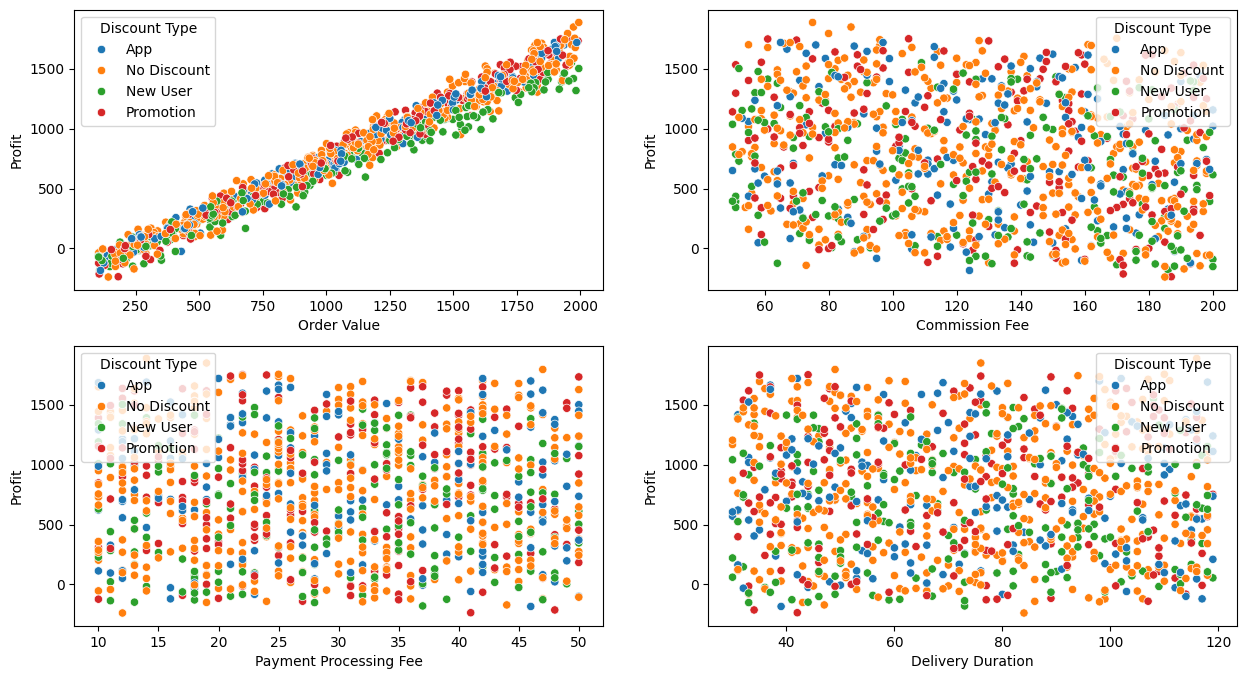

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15,8))
sns.scatterplot(data=df, x='Order Value', y='Profit', hue='Discount Type', ax=axes[0][0])
sns.scatterplot(data=df, x='Commission Fee', y='Profit', hue='Discount Type',ax=axes[0][1])
sns.scatterplot(data=df, x='Payment Processing Fee', y='Profit',hue='Discount Type', ax=axes[1][0])
sns.scatterplot(data=df, x='Delivery Duration', y='Profit',hue='Discount Type', ax=axes[1][1])

圖形分析：
* 訂單金額與獲利呈正相關，其中沒有折扣的訂單獲益屬最高，New User因折扣15%故整體來說獲益較其他分類較少。
* 隨Commission Fee提升，整體獲益呈下降趨勢。
* Payment Processing Fee與獲益未有顯著相關。
* 配送時長與獲益未有顯著相關。

3.5繪製Heatmap以顯示Profit與數值型欄位之關係

<Axes: >

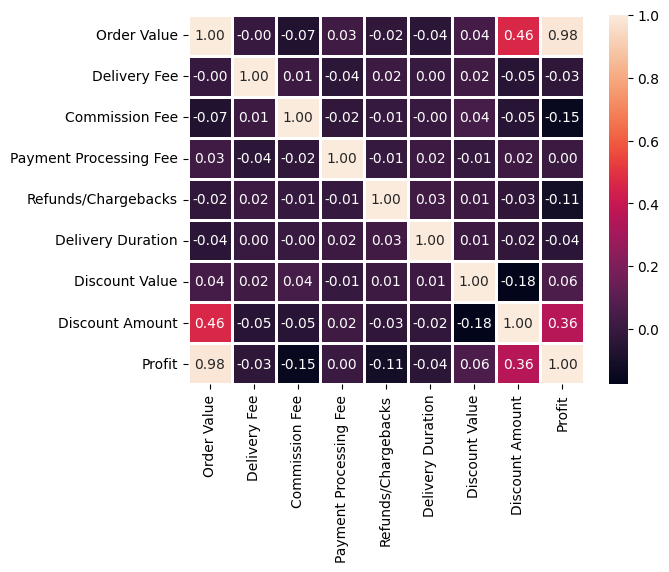

In [ ]:
numeric_df = df.drop(labels='Order ID', axis=1).select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), linewidths = 1, annot = True, fmt = ".2f")

圖形分析：
* 訂單金額與獲益呈高度正相關(皮爾森相關係數0.98)。
* 折扣金額與獲益呈正相關(皮爾森相關係數0.36)。
* 在所有特徵中，Commission Fee與獲益的皮爾森相關係數最低(-0.15)，顯示出最明顯的負相關關係，其次為Refunds/Chargebacks(-0.11)，再來是Delivery Fee(-0.03)與Delivery Duration(-0.04)。

---


四、 模型建立

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

4.1區分特徵X, 目標變數y

In [ ]:
X = df.drop(['Order ID', 'Customer ID', 'Restaurant ID', 'Profit'], axis=1)
y = df['Profit']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Order ID                1000 non-null   int64         
 1   Customer ID             1000 non-null   object        
 2   Restaurant ID           1000 non-null   object        
 3   Order Date and Time     1000 non-null   datetime64[ns]
 4   Delivery Date and Time  1000 non-null   datetime64[ns]
 5   Order Value             1000 non-null   int64         
 6   Delivery Fee            1000 non-null   int64         
 7   Payment Method          1000 non-null   object        
 8   Discounts and Offers    815 non-null    object        
 9   Commission Fee          1000 non-null   int64         
 10  Payment Processing Fee  1000 non-null   int64         
 11  Refunds/Chargebacks     1000 non-null   int64         
 12  Order Hour              1000 non-null   int32    

4.2區分數值型與類別型之特徵

In [ ]:
number_X = X.select_dtypes(include=['int64', 'float64']).columns
category_X = X.select_dtypes(include=['object']).columns

4.3特徵資料預處理

In [ ]:
preprocessor = ColumnTransformer(transformers=[('num_X', StandardScaler(), number_X), ('cat_X', OneHotEncoder(drop='first', handle_unknown='ignore'), category_X)])

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

4.4劃分Train & Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

4.5模型訓練

In [ ]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_X', StandardScaler(),
                                                  Index(['Order Value', 'Delivery Fee', 'Commission Fee',
       'Payment Processing Fee', 'Refunds/Chargebacks', 'Delivery Duration',
       'Discount Value', 'Discount Amount'],
      dtype='object')),
                                                 ('cat_X',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['Payment Method', 'Discounts and Offers', 'Weekday', 'Discount Type',
       'Meal Time'],
      dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

4.6模型評估

In [ ]:
y_pred = pipeline.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 2288.1356491049996
R²: 0.9904691436789457


模型的評估指標顯示：
* MSE為2288.14，代表每筆預測的平均平方誤差約為2288，對應RMSE為47.84，表示大多數預測值與實際利潤差距約在50元以內。
* R²為0.990，代表模型可解釋99%以上的利潤變異，預測準確度高。

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mean_profit = df['Profit'].mean()
relative_error = rmse / mean_profit

print(f"RMSE: {rmse:.2f} 元")
print(f"平均利潤: {mean_profit:.2f} 元")
print(f"預測誤差約佔平均利潤的 {relative_error:.2%}")

RMSE: 47.83 元
平均利潤: 765.94 元
預測誤差約佔平均利潤的 6.25%
